In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the metrics data
with open('out/metrics.json', 'r') as f:
    metrics = json.load(f)

# Prepare data for plotting with multiple runs
data = []
for model_name, runs in metrics.items():
    for run_index, run_metrics in enumerate(runs):  # Iterate over each run
        for metric, values in run_metrics.items():
            for epoch, value in enumerate(values):
                data.append({
                    'Model': model_name.capitalize(),
                    'Run': run_index,
                    'Metric': metric,
                    'Epoch': epoch,
                    'Value': value
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate mean and standard deviation for each model, metric, and epoch
df_summary = df.groupby(['Model', 'Metric', 'Epoch']).agg(
    Mean=('Value', 'mean'),
    Std=('Value', 'std')
).reset_index()

# Calculate the number of runs per model
num_runs = df.groupby('Model')['Run'].nunique()

# Print the number of runs for each model
for model, runs in num_runs.items():
    print(f"Model: {model}, Number of Runs: {runs}")
print()

print(df_summary.head(n=10), end='\n\n')

print('Metrics:', df_summary['Metric'].unique())

Model: Adabn, Number of Runs: 32
Model: Adverserial, Number of Runs: 32
Model: Baseline, Number of Runs: 32
Model: Coral, Number of Runs: 32

   Model       Metric  Epoch       Mean       Std
0  Adabn   source_acc      0   1.000000  0.000000
1  Adabn  source_loss      0   0.000807  0.000291
2  Adabn   target_acc      0   0.889219  0.027856
3  Adabn  target_loss      0   0.300471  0.085421
4  Adabn   total_loss      0  13.934062  0.389946
5  Adabn   total_loss      1   9.750080  0.413766
6  Adabn   total_loss      2   7.930486  0.436764
7  Adabn   total_loss      3   6.595223  0.507507
8  Adabn   total_loss      4   5.575827  0.553192
9  Adabn   total_loss      5   4.645981  0.539332

Metrics: ['source_acc' 'source_loss' 'target_acc' 'target_loss' 'total_loss'
 'total_cls_loss_g' 'total_gen_loss_g' 'total_loss_d' 'total_loss_g'
 'total_cls_loss' 'total_coral_loss']


In [2]:
# Filter for source and target accuracy/loss metrics
filtered_df = df[df['Metric'].isin(['source_acc', 'target_acc', 'source_loss', 'target_loss'])]

# Calculate the maximum values and their standard deviations across runs for each model and metric
max_stats = filtered_df.groupby(['Model', 'Metric', 'Run'])['Value'].max().reset_index()

# Calculate mean and standard deviation of max values across runs
max_accuracies = max_stats.groupby(['Model', 'Metric'])['Value'].agg(['mean', 'std']).unstack()

# Loop through each model and metric to display mean ± std with 3 decimal places
for model, metrics in max_accuracies.iterrows():
    print(f"\nModel: {model}")
    for metric in metrics.index.levels[1]:  # Loop through each metric (e.g., source_acc, target_acc)
        mean_val = metrics[('mean', metric)]
        std_val = metrics[('std', metric)]
        
        # Print formatted output if both mean and std exist
        if pd.notna(mean_val) and pd.notna(std_val):
            print(f"  {metric}: {mean_val:.3f} ± {std_val:.3f}")
        else:
            print('Encountered an N/A')


Model: Adabn
  source_acc: 1.000 ± 0.000
  source_loss: 0.001 ± 0.000
  target_acc: 0.889 ± 0.028
  target_loss: 0.300 ± 0.085

Model: Adverserial
  source_acc: 1.000 ± 0.000
  source_loss: 2.182 ± 0.018
  target_acc: 1.000 ± 0.001
  target_loss: 2.235 ± 0.020

Model: Baseline
  source_acc: 1.000 ± 0.000
  source_loss: 2.270 ± 0.017
  target_acc: 0.837 ± 0.046
  target_loss: 2.280 ± 0.014

Model: Coral
  source_acc: 1.000 ± 0.000
  source_loss: 2.232 ± 0.024
  target_acc: 0.852 ± 0.036
  target_loss: 2.256 ± 0.020


/tmp/ipykernel_64771/1173160631.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=target_acc_df, x='Model', y='Mean', capsize=0.2, palette="viridis")


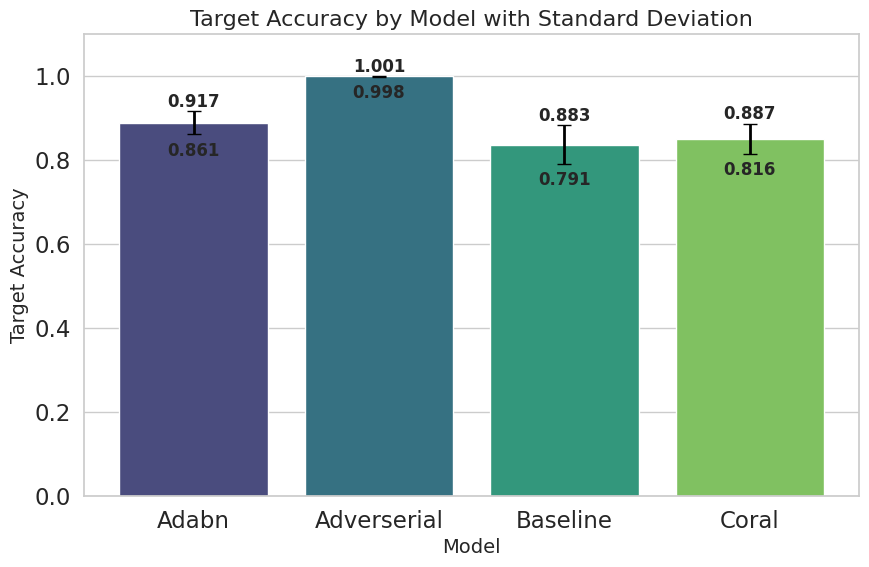

In [3]:
# Set seaborn style for plots
sns.set(style="whitegrid", font_scale=1.5)

# Extract target accuracy means and standard deviations as separate columns
target_acc_df = max_accuracies['mean', 'target_acc'].reset_index()
target_acc_df.columns = ['Model', 'Mean']  # Rename columns for clarity
target_acc_df['Std'] = max_accuracies['std', 'target_acc'].values  # Add standard deviation as a 1D array

# Plot bar chart with error bars for standard deviation
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=target_acc_df, x='Model', y='Mean', capsize=0.2, palette="viridis")

# Add error bars manually with increased thickness for visibility
plt.errorbar(x=range(len(target_acc_df)), y=target_acc_df['Mean'], yerr=target_acc_df['Std'], 
             fmt='none', capsize=5, color='black', linestyle='None', linewidth=2)

# Add value labels on top of each bar
for i, (mean, std) in enumerate(zip(target_acc_df['Mean'], target_acc_df['Std'])):
    ax.text(i, mean + std + 0.01, f"{mean + std:.3f}", ha='center', fontsize=12, fontweight='bold')
    ax.text(i, mean - std - 0.05, f"{mean - std:.3f}", ha='center', fontsize=12, fontweight='bold')

# Adjust y-axis to focus on high accuracy range
plt.ylim(0.0, 1.1)

# Add labels and title
plt.title("Target Accuracy by Model with Standard Deviation", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Target Accuracy", fontsize=14)

# Show the plot
plt.show()

In [4]:
# We only have one sample for Adabn
df = df[df["Model"] != "Adabn"]

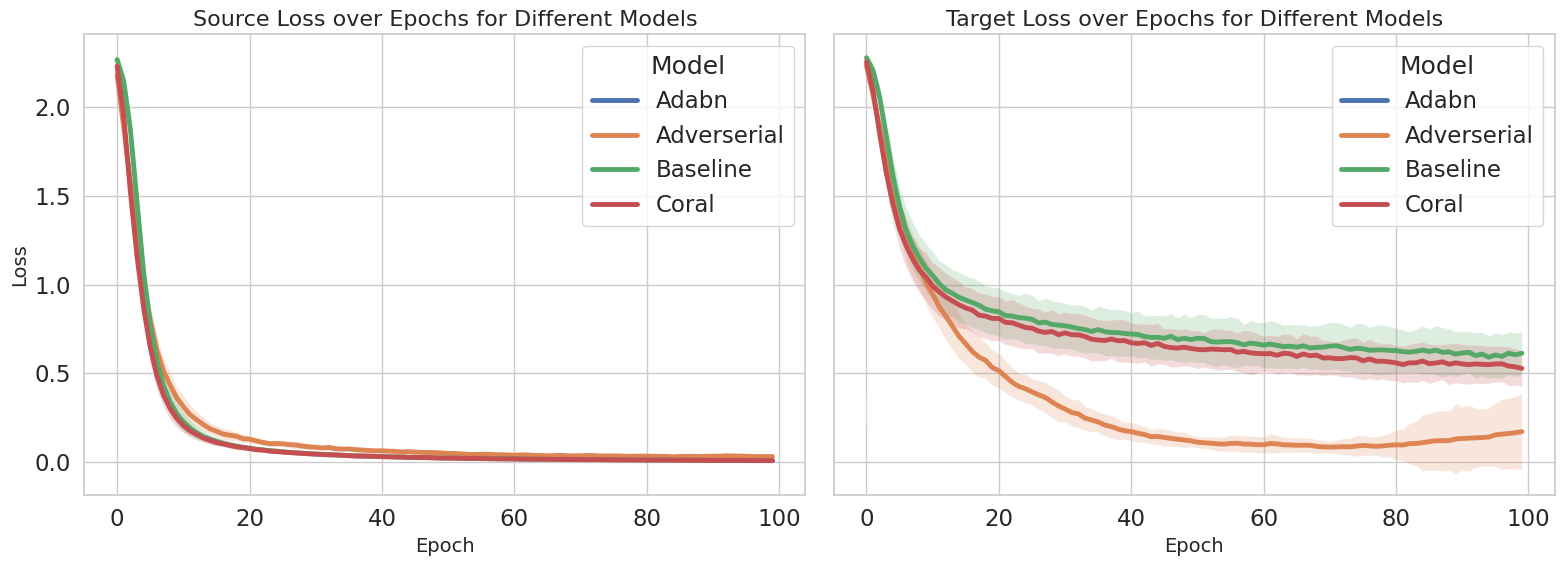

In [5]:
# Create subplots: one for source loss, one for target loss
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plotting Source Loss for each model with standard deviation shading
for model_name in df_summary['Model'].unique():
    model_data = df_summary[(df_summary['Model'] == model_name) & (df_summary['Metric'] == 'source_loss')]
    sns.lineplot(x='Epoch', y='Mean', data=model_data, label=model_name, ax=axes[0], linewidth=3.5)
    axes[0].fill_between(model_data['Epoch'], model_data['Mean'] - model_data['Std'], model_data['Mean'] + model_data['Std'], alpha=0.2)

axes[0].set_title("Source Loss over Epochs for Different Models", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].legend(title="Model")

# Plotting Target Loss for each model with standard deviation shading
for model_name in df_summary['Model'].unique():
    model_data = df_summary[(df_summary['Model'] == model_name) & (df_summary['Metric'] == 'target_loss')]
    sns.lineplot(x='Epoch', y='Mean', data=model_data, label=model_name, ax=axes[1], linewidth=3.5)
    axes[1].fill_between(model_data['Epoch'], model_data['Mean'] - model_data['Std'], model_data['Mean'] + model_data['Std'], alpha=0.2)

axes[1].set_title("Target Loss over Epochs for Different Models", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Loss", fontsize=14)
axes[1].legend(title="Model")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

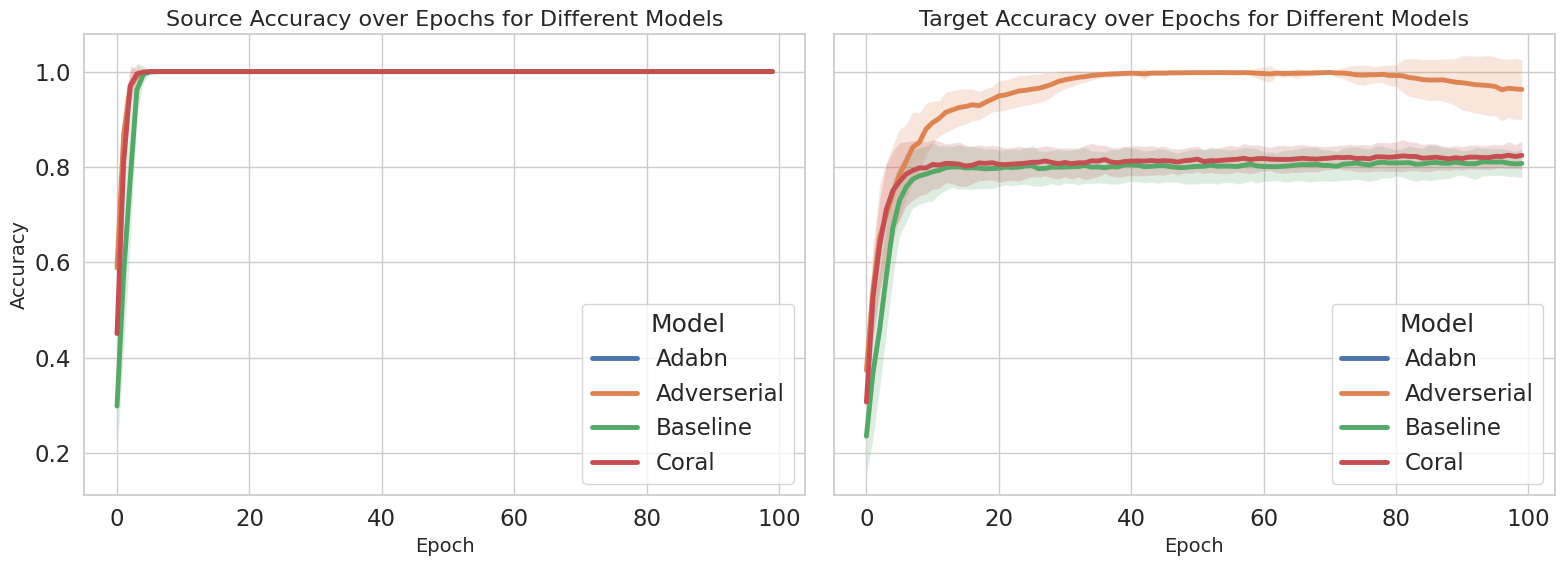

In [6]:
# Create subplots: one for source accuracy, one for target accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plotting Source Accuracy for each model with standard deviation shading
for model_name in df_summary['Model'].unique():
    model_data = df_summary[(df_summary['Model'] == model_name) & (df_summary['Metric'] == 'source_acc')]
    sns.lineplot(x='Epoch', y='Mean', data=model_data, label=model_name, ax=axes[0], linewidth=3.5)
    axes[0].fill_between(model_data['Epoch'], model_data['Mean'] - model_data['Std'], model_data['Mean'] + model_data['Std'], alpha=0.2)

axes[0].set_title("Source Accuracy over Epochs for Different Models", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Accuracy", fontsize=14)
axes[0].legend(title="Model")

# Plotting Target Accuracy for each model with standard deviation shading
for model_name in df_summary['Model'].unique():
    model_data = df_summary[(df_summary['Model'] == model_name) & (df_summary['Metric'] == 'target_acc')]
    sns.lineplot(x='Epoch', y='Mean', data=model_data, label=model_name, ax=axes[1], linewidth=3.5)
    axes[1].fill_between(model_data['Epoch'], model_data['Mean'] - model_data['Std'], model_data['Mean'] + model_data['Std'], alpha=0.2)

axes[1].set_title("Target Accuracy over Epochs for Different Models", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].legend(title="Model")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Hyperparameter tuning

In [2]:
import optuna
import itertools
import pandas as pd

folder = 'out'
study_names = [
    'hypertune_baseline',
    # 'hypertune_coral',
    # 'hypertune_adversarial',
    # 'hypertune_adabn'
]

In [3]:
# Function to generate contour plots for each combination of hyperparameters
def plot_contours(study, search_space):
    # Generate contour plots for each pair of hyperparameters
    param_combinations = list(itertools.combinations(search_space.keys(), 2))
    for params in param_combinations:
        fig = optuna.visualization.plot_contour(study, params=params)
        fig.show()

In [4]:
# Define the search spaces for each study
search_spaces = {
    'hypertune_baseline': {
        'lr': [0.0001, 0.001, 0.01],
        'batch_size': [8, 16, 32, 64],
    },
    'hypertune_coral': {
        'lr': [0.0001, 0.001, 0.01],
        'batch_size': [8, 16, 32, 64],
    },
    'hypertune_adversarial': {
        'lr': [0.0001, 0.001, 0.01],
        'batch_size': [8, 16, 32, 64],
        'coral_weight': [0.1, 0.5, 1, 2, 4],
    },
    'hypertune_adabn': {
        'lr': [0.0001, 0.001, 0.01],
        'batch_size': [8, 16, 32, 64],
        'adversarial_weight': [0.1, 0.5, 1, 2, 4],
    }
}

Analyzing study: hypertune_baseline


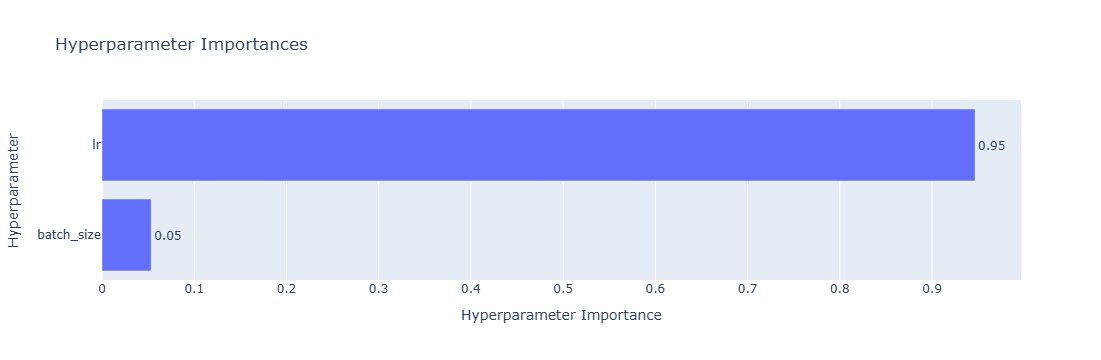

Best hyperparameters:
lr: 0.0001
batch_size: 8
Best value (objective): 0.8119999999999999


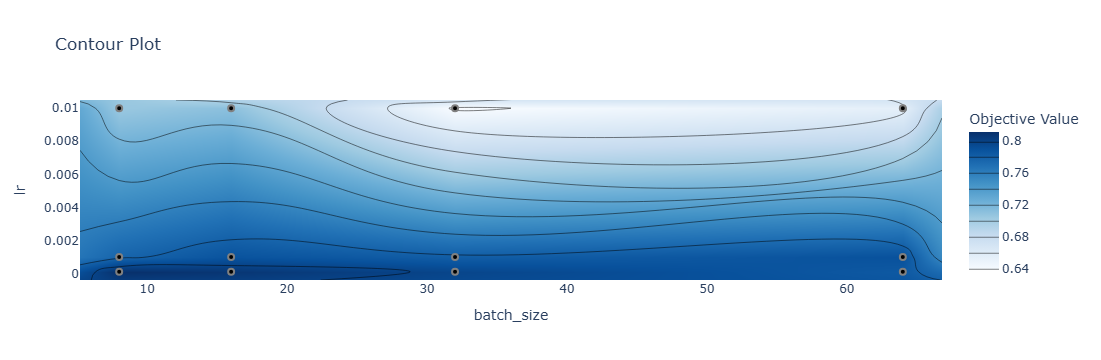

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_lr,system_attrs_grid_id,system_attrs_search_space,state
0,0,0.798,2024-11-08 09:49:55.004215,2024-11-08 09:50:18.203527,0 days 00:00:23.199312,32,0.0001,0,"{'batch_size': [8, 16, 32, 64], 'lr': [0.0001,...",COMPLETE
1,1,0.654,2024-11-08 09:50:18.265432,2024-11-08 09:50:32.161651,0 days 00:00:13.896219,64,0.0100,1,"{'batch_size': [8, 16, 32, 64], 'lr': [0.0001,...",COMPLETE
2,2,0.789,2024-11-08 09:50:32.210520,2024-11-08 09:51:05.888957,0 days 00:00:33.678437,16,0.0010,2,"{'batch_size': [8, 16, 32, 64], 'lr': [0.0001,...",COMPLETE
3,3,0.790,2024-11-08 09:51:05.946799,2024-11-08 09:51:19.223951,0 days 00:00:13.277152,64,0.0010,3,"{'batch_size': [8, 16, 32, 64], 'lr': [0.0001,...",COMPLETE
4,4,0.705,2024-11-08 09:51:19.288435,2024-11-08 09:52:19.664494,0 days 00:01:00.376059,8,0.0100,4,"{'batch_size': [8, 16, 32, 64], 'lr': [0.0001,...",COMPLETE


In [6]:
# Loop over each study and generate visualizations
for study_name in study_names:
    print(f"Analyzing study: {study_name}")

    # Load the study
    study = optuna.load_study(study_name=study_name, storage=f'sqlite:///{folder}/study.db')

    # Visualize the importance of hyperparameters
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    # Print the best hyperparameters
    best_trial = study.best_trial
    print("Best hyperparameters:")
    for param_name, param_value in best_trial.params.items():
        print(f"{param_name}: {param_value}")
    print(f"Best value (objective): {best_trial.value}")
    
    # Get the search space for the current study
    search_space = search_spaces[study_name]

    # Generate contour plots for each pair of hyperparameters
    plot_contours(study, search_space)

    # Retrieve and display the hyperparameter tuning results
    hyper_df = study.trials_dataframe()
    display(hyper_df.head())

In [ ]:
study_name = 'hypertune_baseline'
study = optuna.load_study(study_name=study_name, storage=f'sqlite:///{folder}/study.db')

# Display the full DataFrame for the study if needed
hyper_df = study.trials_dataframe()
display(hyper_df)